In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [2]:
data=pd.read_csv("mgl_stocks_max.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-07-04,523.950012,533.500000,521.000000,530.750000,447.709930,887644
1,2016-07-05,531.000000,532.799988,516.000000,517.500000,436.533081,361954
2,2016-07-07,518.900024,520.799988,504.200012,506.000000,426.832275,300321
3,2016-07-08,508.000000,510.850006,498.600006,502.100006,423.542450,340090
4,2016-07-11,505.200012,511.450012,502.399994,503.350006,424.597015,210953
...,...,...,...,...,...,...,...
1670,2023-04-06,963.000000,985.000000,954.650024,982.700012,982.700012,41429
1671,2023-04-10,991.049988,1024.400024,973.700012,993.349976,993.349976,45086
1672,2023-04-11,980.150024,1002.950012,980.150024,991.349976,991.349976,20938
1673,2023-04-12,991.349976,1015.000000,991.349976,995.599976,995.599976,21408


In [3]:
data.shape

(1675, 7)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1675 entries, 0 to 1674
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1675 non-null   object 
 1   Open       1675 non-null   float64
 2   High       1675 non-null   float64
 3   Low        1675 non-null   float64
 4   Close      1675 non-null   float64
 5   Adj Close  1675 non-null   float64
 6   Volume     1675 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 91.7+ KB


In [5]:
trainData = data.iloc[:,4:5].values
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(1675, 1)

In [6]:
x_train =[]
y_train =[]

for i in range(60,1675):
    x_train.append(trainData[i-60:i,0])
    y_train.append(trainData[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [7]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(optimizer='adam',loss="mean_squared_error")

In [8]:
hist = model.fit(x_train, y_train, epochs = 10, batch_size = 32, verbose = 2)

Epoch 1/10
51/51 - 36s - loss: 0.0257 - 36s/epoch - 701ms/step
Epoch 2/10
51/51 - 26s - loss: 0.0072 - 26s/epoch - 511ms/step
Epoch 3/10
51/51 - 27s - loss: 0.0072 - 27s/epoch - 533ms/step
Epoch 4/10
51/51 - 24s - loss: 0.0064 - 24s/epoch - 469ms/step
Epoch 5/10
51/51 - 25s - loss: 0.0055 - 25s/epoch - 495ms/step
Epoch 6/10
51/51 - 26s - loss: 0.0053 - 26s/epoch - 515ms/step
Epoch 7/10
51/51 - 26s - loss: 0.0050 - 26s/epoch - 508ms/step
Epoch 8/10
51/51 - 25s - loss: 0.0045 - 25s/epoch - 500ms/step
Epoch 9/10
51/51 - 24s - loss: 0.0047 - 24s/epoch - 472ms/step
Epoch 10/10
51/51 - 24s - loss: 0.0039 - 24s/epoch - 470ms/step


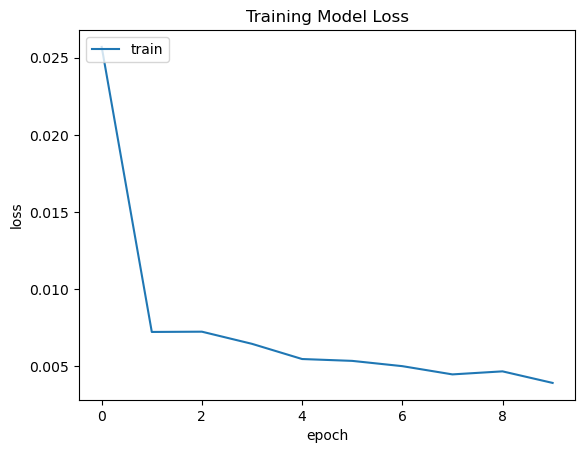

In [9]:
plt.plot(hist.history['loss'])
plt.title('Training Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [10]:
testData = pd.read_csv('mgl_stocks_max.csv')
testData["Close"] = pd.to_numeric(testData.Close,errors='coerce')
testData = testData.dropna()
testData = testData.iloc[:,4:5]
y_test = testData.iloc[60:,0:].values
inputClosing = testData.iloc[:,0:].values
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
x_test = []
length = len(testData)
timestep = 60
for i in range(timestep,length):
    x_test.append(inputClosing_scaled[i-timestep:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test.shape

(1615, 60, 1)

In [11]:
y_pred = model.predict(x_test)
y_pred

51/51 [==============================] - 5s 60ms/step


array([[0.16443476],
       [0.17051527],
       [0.17872638],
       ...,
       [0.5865724 ],
       [0.5882104 ],
       [0.59225553]], dtype=float32)

In [12]:
predicted_price = sc.inverse_transform(y_pred)

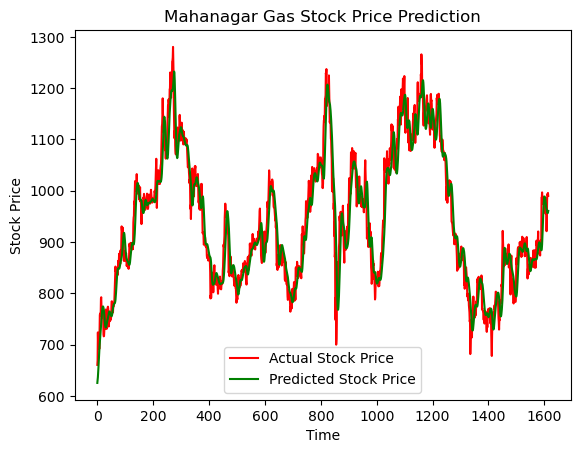

In [13]:
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Mahanagar Gas Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [14]:
last_data = trainData[-60:]
last_data = np.reshape(last_data, (1,60,1))
future_prices = []
for i in range(10):
    prediction = model.predict(last_data)
    future_prices.append(prediction)
    last_data = np.concatenate((last_data[:,1:,:], prediction.reshape(1,1,1)), axis=1)
predictions = np.concatenate(future_prices, axis=0)
predictions = sc.inverse_transform(predictions.reshape(-1, 1))
print(predictions)

1/1 [==============================] - 0s 50ms/step
[[965.1645 ]
 [969.8352 ]
 [973.626  ]
 [976.09064]
 [977.2374 ]
 [977.3375 ]
 [976.747  ]
 [975.7881 ]
 [974.69556]
 [973.60767]]


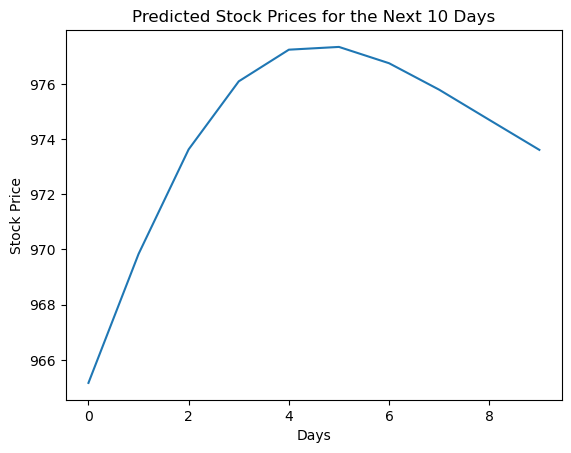

In [15]:
plt.plot(predictions)
plt.title('Predicted Stock Prices for the Next 10 Days')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()